In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# 读取用户申购赎回数据表
user_balance= pd.read_csv('user_balance_table.csv',index_col='report_date')
# 根据report_date，进行求和
rawData = user_balance.groupby(by=['report_date']).sum()
# 去除该方案不用的列，只选择本次有用的列
purchaseRedeemData = rawData[['total_purchase_amt','total_redeem_amt']]
# 打印purchaseRedeemData
print(purchaseRedeemData)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


             total_purchase_amt  total_redeem_amt
report_date                                      
20130701               32488348           5525022
20130702               29037390           2554548
20130703               27270770           5953867
20130704               18321185           6410729
20130705               11648749           2763587
...                         ...               ...
20140827              302194801         468164147
20140828              245082751         297893861
20140829              267554713         273756380
20140830              199708772         196374134
20140831              275090213         292943033

[427 rows x 2 columns]


In [3]:
# 只选择资金的流入数据
purchaseTrainData = purchaseRedeemData[['total_purchase_amt']]
# purchaseTrainData = purchaseRedeemData[['total_redeem_amt']]
# 将数据转换成时间序列格式，以便于后期处理
purchaseTrainData.index = pd.to_datetime(purchaseTrainData.index,format='%Y%m%d')
# 打印资金的流入出数据
print(purchaseTrainData)

             total_purchase_amt
report_date                    
2013-07-01             32488348
2013-07-02             29037390
2013-07-03             27270770
2013-07-04             18321185
2013-07-05             11648749
...                         ...
2014-08-27            302194801
2014-08-28            245082751
2014-08-29            267554713
2014-08-30            199708772
2014-08-31            275090213

[427 rows x 1 columns]


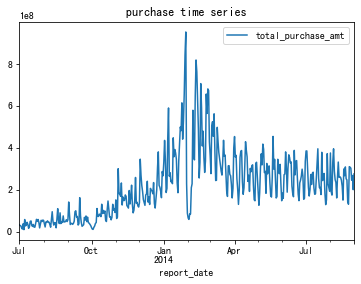

In [4]:
purchaseTrainData.sort_index().plot(title = 'purchase time series')

In [5]:

purchaseTrainSeries = purchaseTrainData.dropna().total_purchase_amt
# purchaseTrainSeries = purchaseTrainData.dropna().total_redeem_amt
print(purchaseTrainSeries)

report_date
2013-07-01     32488348
2013-07-02     29037390
2013-07-03     27270770
2013-07-04     18321185
2013-07-05     11648749
                ...    
2014-08-27    302194801
2014-08-28    245082751
2014-08-29    267554713
2014-08-30    199708772
2014-08-31    275090213
Name: total_purchase_amt, Length: 427, dtype: int64


In [6]:
import statsmodels.tsa.stattools as ts

In [7]:
# 进行ADF单位根检验，并查看结果
ts.adfuller(purchaseTrainSeries)

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

##### 从以上结果得出我们不能拒绝H0,所以该时间序列不平稳

In [8]:
#### 为了处理不平稳序列,我们先做一次一阶差分,并检验
purchaseTrainSeries_diff_1 = purchaseTrainSeries.diff().dropna()
ts.adfuller(purchaseTrainSeries_diff_1)

(-7.947102224652343,
 3.198186862488185e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

##### 很好,现在我们得到了平稳的序列

In [9]:
from statsmodels.tsa import stattools

LjungBox=stattools.q_stat(stattools.acf(purchaseTrainSeries),len(purchaseTrainSeries))
print(LjungBox[1][-1])

0.0


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


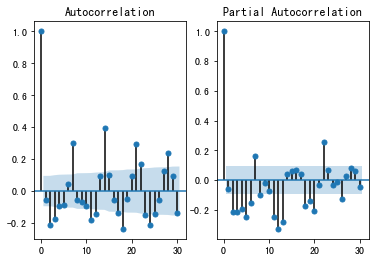

In [10]:
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
# 将画面一分为二
# 第一个画自相关图
# 第二个画偏自相关图


# 将画面一分为二
axe1=plt.subplot(121)
axe2=plt.subplot(122)
#在第一个画面中画出序列的自相关系数图 
plot1=plot_acf(purchaseTrainSeries_diff_1,lags=30,ax=axe1)
#在第二个画面中画出序列的偏自相关系数图
plot2=plot_pacf(purchaseTrainSeries_diff_1,lags=30,ax=axe2)

In [11]:
from statsmodels.tsa import arima_model
import sys

# 忽略 ValueWarning
import warnings
warnings.filterwarnings('ignore')

aicValue_Dif = sys.maxsize
p_Dif = 0
q_Dif = 0

for p in range(0,10):
    for q in range(0,10):
        try:
            model = arima_model.ARIMA(purchaseTrainSeries,order=(p,1,q)).fit()
            aicValue = model.aic
            print('p=' + str(p) + '   q=' + str(q) + '   aic=' + str(aicValue))
            if aicValue <  aicValue_Dif:
                aicValue_Dif = aicValue
                p_Dif = p
                q_Dif = q
        except:
            continue

print('p_Dif=' + str(p_Dif) + '   q_Dif=' + str(q_Dif)  +  '   aicValue_Dif=' + str(aicValue_Dif))

p=0   q=0   aic=16841.460203357445
p=0   q=1   aic=16840.65879097423
p=0   q=2   aic=16768.588254718212
p=0   q=3   aic=16749.329831759416
p=0   q=4   aic=16751.309186957347
p=0   q=5   aic=16753.298607670124
p=0   q=6   aic=16754.895467015613
p=0   q=7   aic=16737.509977528156
p=0   q=8   aic=16737.561777246472
p=0   q=9   aic=16739.216112297603
p=1   q=0   aic=16841.9752200592
p=1   q=1   aic=16765.542397723617
p=1   q=2   aic=16753.1081972759
p=1   q=3   aic=16751.310435991865
p=1   q=4   aic=16747.349897650038
p=1   q=5   aic=16748.65322730548
p=1   q=6   aic=16748.649510873474
p=1   q=7   aic=16737.502410447283
p=2   q=0   aic=16823.96105890665
p=2   q=1   aic=16748.624487466237
p=2   q=2   aic=16748.745570132123
p=2   q=3   aic=16750.61328108243
p=2   q=4   aic=16694.109169255076
p=2   q=5   aic=16691.841441220684
p=2   q=6   aic=16692.582391032625
p=2   q=7   aic=16739.421124524542
p=3   q=0   aic=16806.12709020872
p=3   q=1   aic=16748.811605237388
p=3   q=2   aic=16750.6679239

In [12]:
model = arima_model.ARIMA(purchaseTrainSeries,order=(p_Dif,1,q_Dif)).fit()
model.conf_int()

,0,1
const,-574086.641223,1.713063e+06
ar.L1.D.total_purchase_amt,0.889501,1.355017e+00
ar.L2.D.total_purchase_amt,-0.870515,-4.230231e-02
ar.L3.D.total_purchase_amt,-0.855508,-6.558363e-02
ar.L4.D.total_purchase_amt,0.099175,5.247081e-01
ar.L5.D.total_purchase_amt,-0.305936,5.790578e-03
ar.L6.D.total_purchase_amt,-0.154585,1.375725e-01
ar.L7.D.total_purchase_amt,0.079097,3.607744e-01
ar.L8.D.total_purchase_amt,-0.387833,-1.969012e-01
ma.L1.D.total_purchase_amt,-1.771052,-1.307220e+00


In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

LjungBox = acorr_ljungbox(model.resid,lags=7)
print(LjungBox[1][-1])

0.8224280637171358


In [14]:
purchase_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
purchase_pred 

2014-09-01    3.206019e+08
2014-09-02    3.290633e+08
2014-09-03    3.086676e+08
2014-09-04    2.562200e+08
2014-09-05    2.282802e+08
2014-09-06    2.043380e+08
2014-09-07    2.431774e+08
2014-09-08    2.855655e+08
2014-09-09    3.147261e+08
2014-09-10    3.008356e+08
2014-09-11    2.631969e+08
2014-09-12    2.310595e+08
2014-09-13    2.242829e+08
2014-09-14    2.555588e+08
2014-09-15    2.970212e+08
2014-09-16    3.225679e+08
2014-09-17    3.097653e+08
2014-09-18    2.718784e+08
2014-09-19    2.360778e+08
2014-09-20    2.288810e+08
2014-09-21    2.556789e+08
2014-09-22    2.957925e+08
2014-09-23    3.204239e+08
2014-09-24    3.109887e+08
2014-09-25    2.762445e+08
2014-09-26    2.423772e+08
2014-09-27    2.352985e+08
2014-09-28    2.602363e+08
2014-09-29    2.988136e+08
2014-09-30    3.228113e+08
Freq: D, dtype: float64

In [15]:
model.aic

16653.320732214863

### 现在purchase预测的工作写完了,我们用同样的方法预测redeem

In [16]:
# 只选择资金的流入数据
redeemTrainData = purchaseRedeemData[['total_redeem_amt']]

# 将数据转换成时间序列格式，以便于后期处理
redeemTrainData.index = pd.to_datetime(purchaseTrainData.index,format='%Y%m%d')
# 打印资金的流入出数据
print(redeemTrainData)

             total_redeem_amt
report_date                  
2013-07-01            5525022
2013-07-02            2554548
2013-07-03            5953867
2013-07-04            6410729
2013-07-05            2763587
...                       ...
2014-08-27          468164147
2014-08-28          297893861
2014-08-29          273756380
2014-08-30          196374134
2014-08-31          292943033

[427 rows x 1 columns]


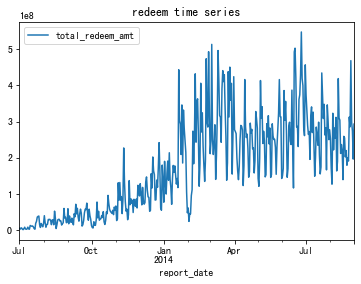

In [17]:
redeemTrainData.sort_index().plot(title = 'redeem time series')

In [18]:

redeemTrainSeries = redeemTrainData.dropna().total_redeem_amt
print(redeemTrainSeries)

report_date
2013-07-01      5525022
2013-07-02      2554548
2013-07-03      5953867
2013-07-04      6410729
2013-07-05      2763587
                ...    
2014-08-27    468164147
2014-08-28    297893861
2014-08-29    273756380
2014-08-30    196374134
2014-08-31    292943033
Name: total_redeem_amt, Length: 427, dtype: int64


In [19]:
# 进行ADF单位根检验，并查看结果
ts.adfuller(redeemTrainSeries)

(-1.372413679828339,
 0.5954275877949474,
 13,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15816.780952766481)

#### 好吧,这个时间序列也是不平稳的

In [20]:
#### 为了处理不平稳序列,我们先做一次一阶差分,并检验
redeemTrainSeries_diff_1 = redeemTrainSeries.diff().dropna()
ts.adfuller(redeemTrainSeries_diff_1)

(-11.69198690696884,
 1.6443717458497645e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

In [21]:
from statsmodels.tsa import stattools

LjungBox=stattools.q_stat(stattools.acf(redeemTrainSeries),len(redeemTrainSeries))
print(LjungBox[1][-1])

0.0


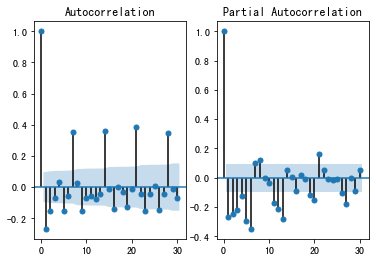

In [22]:
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
# 将画面一分为二
# 第一个画自相关图
# 第二个画偏自相关图


# 将画面一分为二
axe1=plt.subplot(121)
axe2=plt.subplot(122)
#在第一个画面中画出序列的自相关系数图 
plot1=plot_acf(redeemTrainSeries_diff_1,lags=30,ax=axe1)
#在第二个画面中画出序列的偏自相关系数图
plot2=plot_pacf(redeemTrainSeries_diff_1,lags=30,ax=axe2)

In [23]:


# 忽略 ValueWarning
import warnings
warnings.filterwarnings('ignore')

aicValue_Dif = sys.maxsize
p_Dif = 0
q_Dif = 0

for p in range(0,10):
    for q in range(0,10):
        try:
            model = arima_model.ARIMA(redeemTrainSeries,order=(p,1,q)).fit()
            aicValue = model.aic
            print('p=' + str(p) + '   q=' + str(q) + '   aic=' + str(aicValue))
            if aicValue <  aicValue_Dif:
                aicValue_Dif = aicValue
                p_Dif = p
                q_Dif = q
        except:
            continue

print('p_Dif=' + str(p_Dif) + '   q_Dif=' + str(q_Dif)  +  '   aicValue_Dif=' + str(aicValue_Dif))

p=0   q=0   aic=16724.29952170823
p=0   q=1   aic=16637.466978692315
p=0   q=2   aic=16594.832753659313
p=0   q=3   aic=16593.51136823857
p=0   q=4   aic=16594.0343381405
p=0   q=5   aic=16595.150892412163
p=0   q=6   aic=16594.791883849673
p=0   q=7   aic=16574.951532738687
p=0   q=8   aic=16571.66718482116
p=0   q=9   aic=16560.127642404277
p=1   q=0   aic=16694.36526233143
p=1   q=1   aic=16593.97883070426
p=1   q=2   aic=16594.224969288414
p=1   q=3   aic=16594.100739454545
p=1   q=4   aic=16595.430917702783
p=1   q=5   aic=16597.06051748052
p=1   q=6   aic=16592.86882021851
p=1   q=7   aic=16575.53584185024
p=1   q=8   aic=16565.493619560737
p=2   q=0   aic=16670.067632894814
p=2   q=1   aic=16593.779291325685
p=2   q=2   aic=16595.122186532462
p=2   q=3   aic=16592.90730988623
p=2   q=5   aic=16549.82181920138
p=2   q=6   aic=16544.44399028976
p=2   q=7   aic=16571.02975942829
p=2   q=8   aic=16525.3219257312
p=2   q=9   aic=16508.07602686743
p=3   q=0   aic=16651.280708982402
p=

In [24]:
model = arima_model.ARIMA(redeemTrainSeries,order=(p_Dif,1,q_Dif)).fit()
model.conf_int()

,0,1
const,-11408.939566,1.360789e+06
ar.L1.D.total_redeem_amt,-0.894193,-6.302204e-01
ar.L2.D.total_redeem_amt,-0.570258,-2.352369e-01
ar.L3.D.total_redeem_amt,-0.630798,-3.069898e-01
ar.L4.D.total_redeem_amt,-0.605638,-2.754307e-01
ar.L5.D.total_redeem_amt,-0.637419,-3.066921e-01
ar.L6.D.total_redeem_amt,-0.583494,-2.666795e-01
ar.L7.D.total_redeem_amt,0.374402,6.895737e-01
ar.L8.D.total_redeem_amt,0.161500,3.853535e-01
ma.L1.D.total_redeem_amt,0.064470,2.829466e-01


In [25]:

LjungBox = acorr_ljungbox(model.resid,lags=7)
print(LjungBox[1][-1])

0.8697738737434733


In [26]:
redeem_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
redeem_pred 

2014-09-01    3.687988e+08
2014-09-02    3.188757e+08
2014-09-03    3.407753e+08
2014-09-04    3.291667e+08
2014-09-05    2.572588e+08
2014-09-06    2.381331e+08
2014-09-07    2.231166e+08
2014-09-08    3.608751e+08
2014-09-09    2.950576e+08
2014-09-10    3.442243e+08
2014-09-11    3.168221e+08
2014-09-12    2.640071e+08
2014-09-13    2.348937e+08
2014-09-14    2.309726e+08
2014-09-15    3.586077e+08
2014-09-16    2.966446e+08
2014-09-17    3.540085e+08
2014-09-18    3.143170e+08
2014-09-19    2.750669e+08
2014-09-20    2.349917e+08
2014-09-21    2.417693e+08
2014-09-22    3.568582e+08
2014-09-23    3.009123e+08
2014-09-24    3.627906e+08
2014-09-25    3.135164e+08
2014-09-26    2.859231e+08
2014-09-27    2.353069e+08
2014-09-28    2.531158e+08
2014-09-29    3.543597e+08
2014-09-30    3.067064e+08
Freq: D, dtype: float64

In [27]:
result = pd.DataFrame()
result['report_date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values
result

,report_date,purchase,redeem
0,2014-09-01,3.206019e+08,3.687988e+08
1,2014-09-02,3.290633e+08,3.188757e+08
2,2014-09-03,3.086676e+08,3.407753e+08
3,2014-09-04,2.562200e+08,3.291667e+08
4,2014-09-05,2.282802e+08,2.572588e+08
5,2014-09-06,2.043380e+08,2.381331e+08
6,2014-09-07,2.431774e+08,2.231166e+08
7,2014-09-08,2.855655e+08,3.608751e+08
8,2014-09-09,3.147261e+08,2.950576e+08
9,2014-09-10,3.008356e+08,3.442243e+08


In [28]:
result['report_date'] = result['report_date'].apply(lambda x: str(x).replace('-','')[:8])

In [29]:
result.to_csv('tsa_base.csv')

#### 提交的结果score只有105.24,还有很大的提升空间